In [49]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from upsetplot import UpSet, from_memberships
import scipy.stats as stats
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

file_path = "../data/Telecom Customers Churn.csv"
df = pd.read_csv(file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
# Convert TotalCharges to numeric, coercing invalid entries to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check for missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print("Missing Values:\n", missing_values)

# Replace missing TotalCharges with 0 (for customers with tenure = 0)
df['TotalCharges'].fillna(0, inplace=True)

print("\nMissing Values After Imputation:\n", df.isnull().sum())


Missing Values:
 Series([], dtype: int64)

Missing Values After Imputation:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [9]:
# Remove customerID from categorical columns
categorical_cols = df.select_dtypes(include='object').columns.tolist()
if 'customerID' in categorical_cols:
    categorical_cols.remove('customerID')

# Create a summary dictionary
summary_data = []
for col in categorical_cols:
    counts = df[col].value_counts(normalize=True).round(3) * 100  # percentages
    for category, percent in counts.items():
        summary_data.append({
            'Feature': col,
            'Category': category,
            'Percentage': percent
        })

eda_summary_df = pd.DataFrame(summary_data)
eda_summary_df.sort_values(by=['Feature', 'Percentage'], ascending=[True, False], inplace=True)
eda_summary_df

,Feature,Category,Percentage
41,Churn,No,73.5
42,Churn,Yes,26.5
32,Contract,Month-to-month,55.0
33,Contract,Two year,24.1
34,Contract,One year,20.9
4,Dependents,No,70.0
5,Dependents,Yes,30.0
20,DeviceProtection,No,43.9
21,DeviceProtection,Yes,34.4
22,DeviceProtection,No internet service,21.7


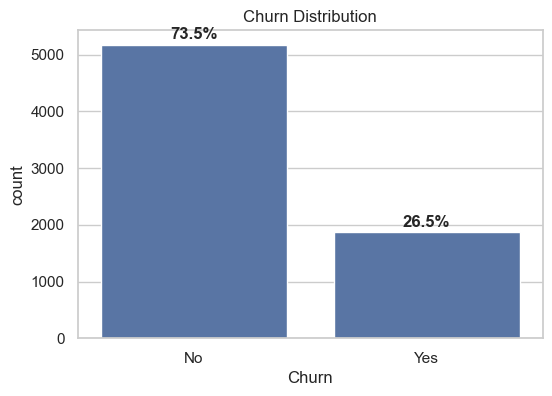

In [53]:
sns.set(style="whitegrid")

# Calculate churn value counts and percentages
churn_counts = df['Churn'].value_counts()
churn_percent = df['Churn'].value_counts(normalize=True) * 100

plt.figure(figsize=(6, 4))
ax = sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")

for i, count in enumerate(churn_counts):
    pct = churn_percent[i]
    ax.text(i, count + 100, f'{pct:.1f}%', ha='center', fontsize=12, fontweight='bold')


plt.savefig("../plots/churn_distribution_plot.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
#### 1. Churn Distribution
### Around **26.5%** of customers churned while **73.5%** stayed.
### Indicates a class imbalance which should be addressed during model training (e.g., SMOTE, stratified sampling).

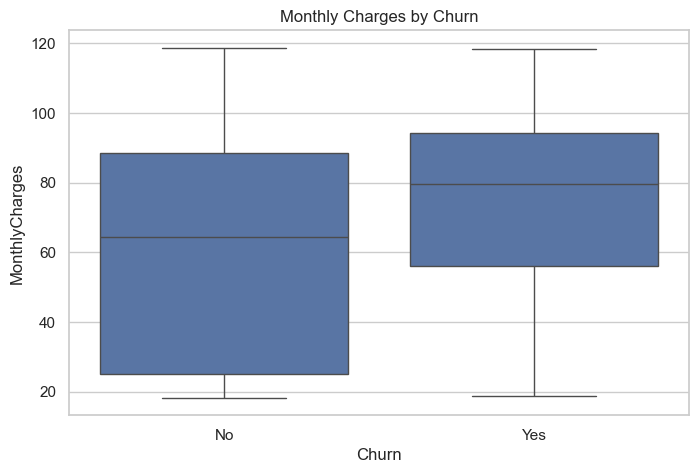

In [55]:
# Boxplot of MonthlyCharges by Churn
plt.figure(figsize=(8, 5))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title("Monthly Charges by Churn")
plt.savefig("../plots/monthly_charges_by_churn.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#### 2. Monthly Charges by Churn
#### Customers who churned tend to have **higher monthly charges** on average.
#### Suggests that cost-sensitive customers are more prone to churn.

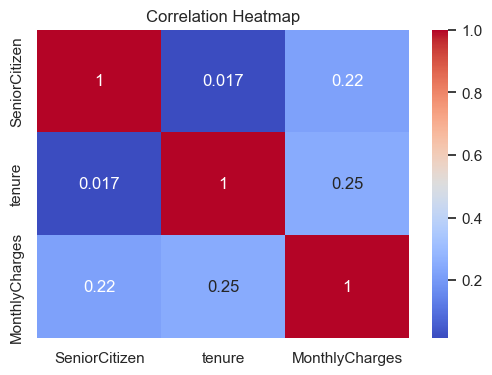

In [57]:
# Correlation heatmap for numeric features
plt.figure(figsize=(6, 4))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.savefig("../plots/correlation_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#### 3. Correlation Heatmap
#### Strong positive correlation between **tenure and total charges**.
#### Moderate correlation between **monthly charges and total charges**.
#### Minimal correlation between other features and churn directly.

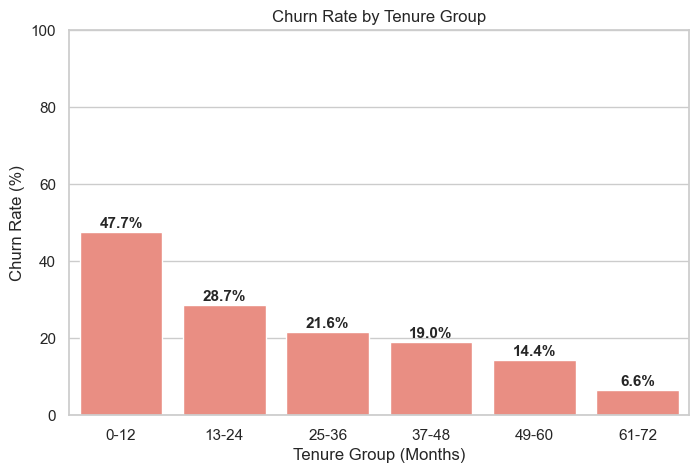

In [59]:
# Create tenure groups
bins = [0, 12, 24, 36, 48, 60, 72]
labels = ['0-12', '13-24', '25-36', '37-48', '49-60', '61-72']
df['TenureGroup'] = pd.cut(df['tenure'], bins=bins, labels=labels, right=True)

# Calculate churn rate by tenure group
churn_by_tenure = df.groupby('TenureGroup')['Churn'].value_counts(normalize=True).unstack().fillna(0) * 100

# Plot churn rate with percentage labels
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=churn_by_tenure.index, y=churn_by_tenure['Yes'], color='salmon')
plt.ylabel("Churn Rate (%)")
plt.xlabel("Tenure Group (Months)")
plt.title("Churn Rate by Tenure Group")
plt.ylim(0, 100)

# Add percentage labels above bars
for i, value in enumerate(churn_by_tenure['Yes']):
    ax.text(i, value + 1, f'{value:.1f}%', ha='center', fontsize=11, fontweight='bold')

plt.savefig("../plots/churn_rate_by_tenure_group.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
#### 4. Churn Rate by Tenure Group
#### Customers with shorter tenure (0-12 months) show the highest churn rate (~47%).
#### Churn rates steadily decline with increased customer tenure.
#### Indicates the need for strong onboarding and early engagement strategies.

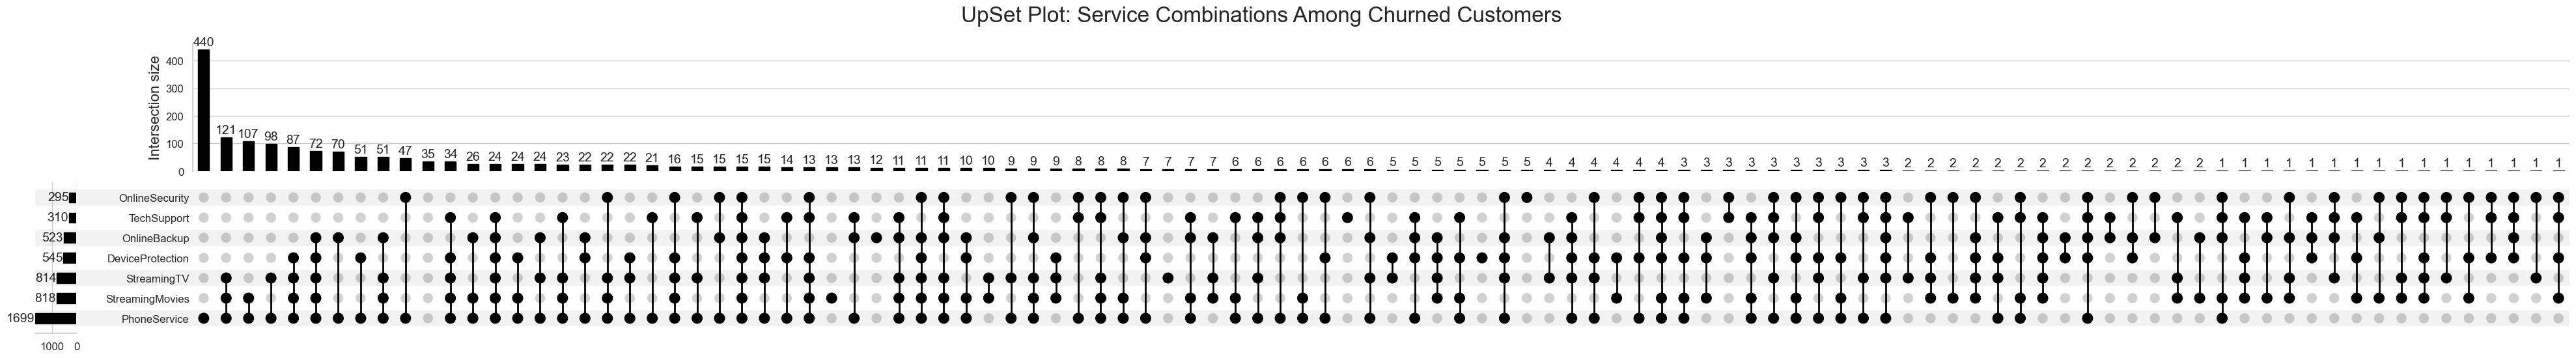

In [61]:
matplotlib.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# Filter churned customers
df_churned = df[df['Churn'] == 'Yes']

# Services to analyze
selected_services = [
    'PhoneService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'
]

# Build membership combinations
memberships_churn = [
    tuple(service for service in selected_services if row[service] == 'Yes')
    for _, row in df_churned.iterrows()
]

# Create upset data
upset_data_churn = from_memberships(memberships_churn)

# Plot
fig = plt.figure(figsize=(40, 24))  
upset = UpSet(upset_data_churn, subset_size='count', show_counts=True, sort_by='cardinality')
upset.plot(fig=fig)
fig.suptitle("UpSet Plot: Service Combinations Among Churned Customers", fontsize=24)

fig.savefig("../plots/churned_customers_upset_plot_large.png", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
#### 6. UpSet Plot: Churned Customers Only
#### Most churned users had **minimal services**, notably only PhoneService or streaming services.
#### Few churned customers had full service packages, reinforcing the idea that bundled services enhance retention.

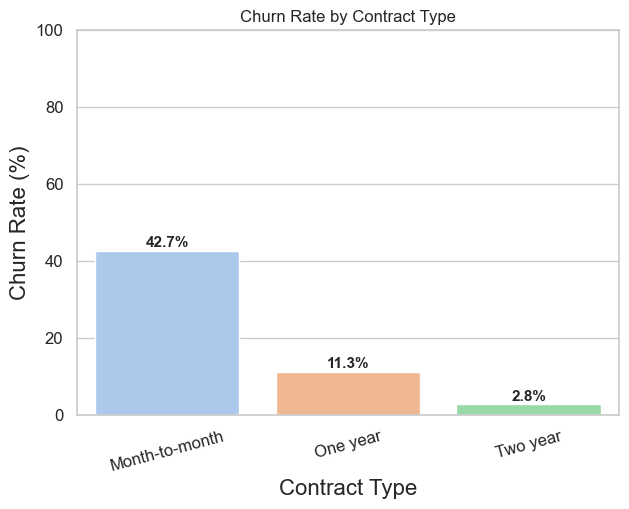

In [63]:
# Calculate churn rate by contract type
churn_by_contract = df.groupby('Contract')['Churn'].value_counts(normalize=True).unstack().fillna(0) * 100

# Plot churn rate with percentage labels
plt.figure(figsize=(7, 5))
ax = sns.barplot(x=churn_by_contract.index, y=churn_by_contract['Yes'], palette='pastel')
plt.ylabel("Churn Rate (%)")
plt.xlabel("Contract Type")
plt.title("Churn Rate by Contract Type")
plt.ylim(0, 100)

# Add percentage labels above bars
for i, value in enumerate(churn_by_contract['Yes']):
    ax.text(i, value + 1, f'{value:.1f}%', ha='center', fontsize=11, fontweight='bold')

plt.xticks(rotation=15)

plt.savefig("../plots/churn_rate_by_contract_type.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
#### 7. Churn Rate by Contract Type
#### **Month-to-month** customers show the highest churn rate (~43%).
#### Churn rate drops significantly for **1-year (~11%)** and **2-year (~3%)** contracts.
#### Long-term contracts reduce churn, possibly due to commitment or promotional offers.

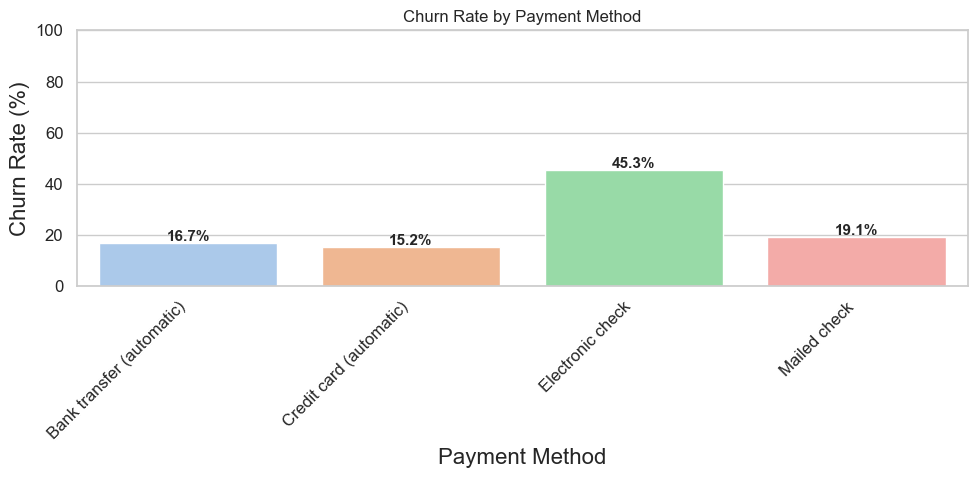

In [65]:
# Calculate churn rate by payment method
churn_by_payment = df.groupby('PaymentMethod')['Churn'].value_counts(normalize=True).unstack().fillna(0) * 100

# Plot churn rate with percentage labels
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=churn_by_payment.index, y=churn_by_payment['Yes'], palette='pastel')
plt.ylabel("Churn Rate (%)")
plt.xlabel("Payment Method")
plt.title("Churn Rate by Payment Method")
plt.ylim(0, 100)

# Add percentage labels above bars
for i, value in enumerate(churn_by_payment['Yes']):
    ax.text(i, value + 1, f'{value:.1f}%', ha='center', fontsize=11, fontweight='bold')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("../plots/churn_rate_by_payment_method.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
#### 8. Churn Rate by Payment Method
#### Customers using **Electronic check** have the highest churn (~45%).
#### Lowest churn among customers using **Credit Card or Bank Transfer (automatic)**.
#### Indicates a link between churn and payment convenience or digital literacy.


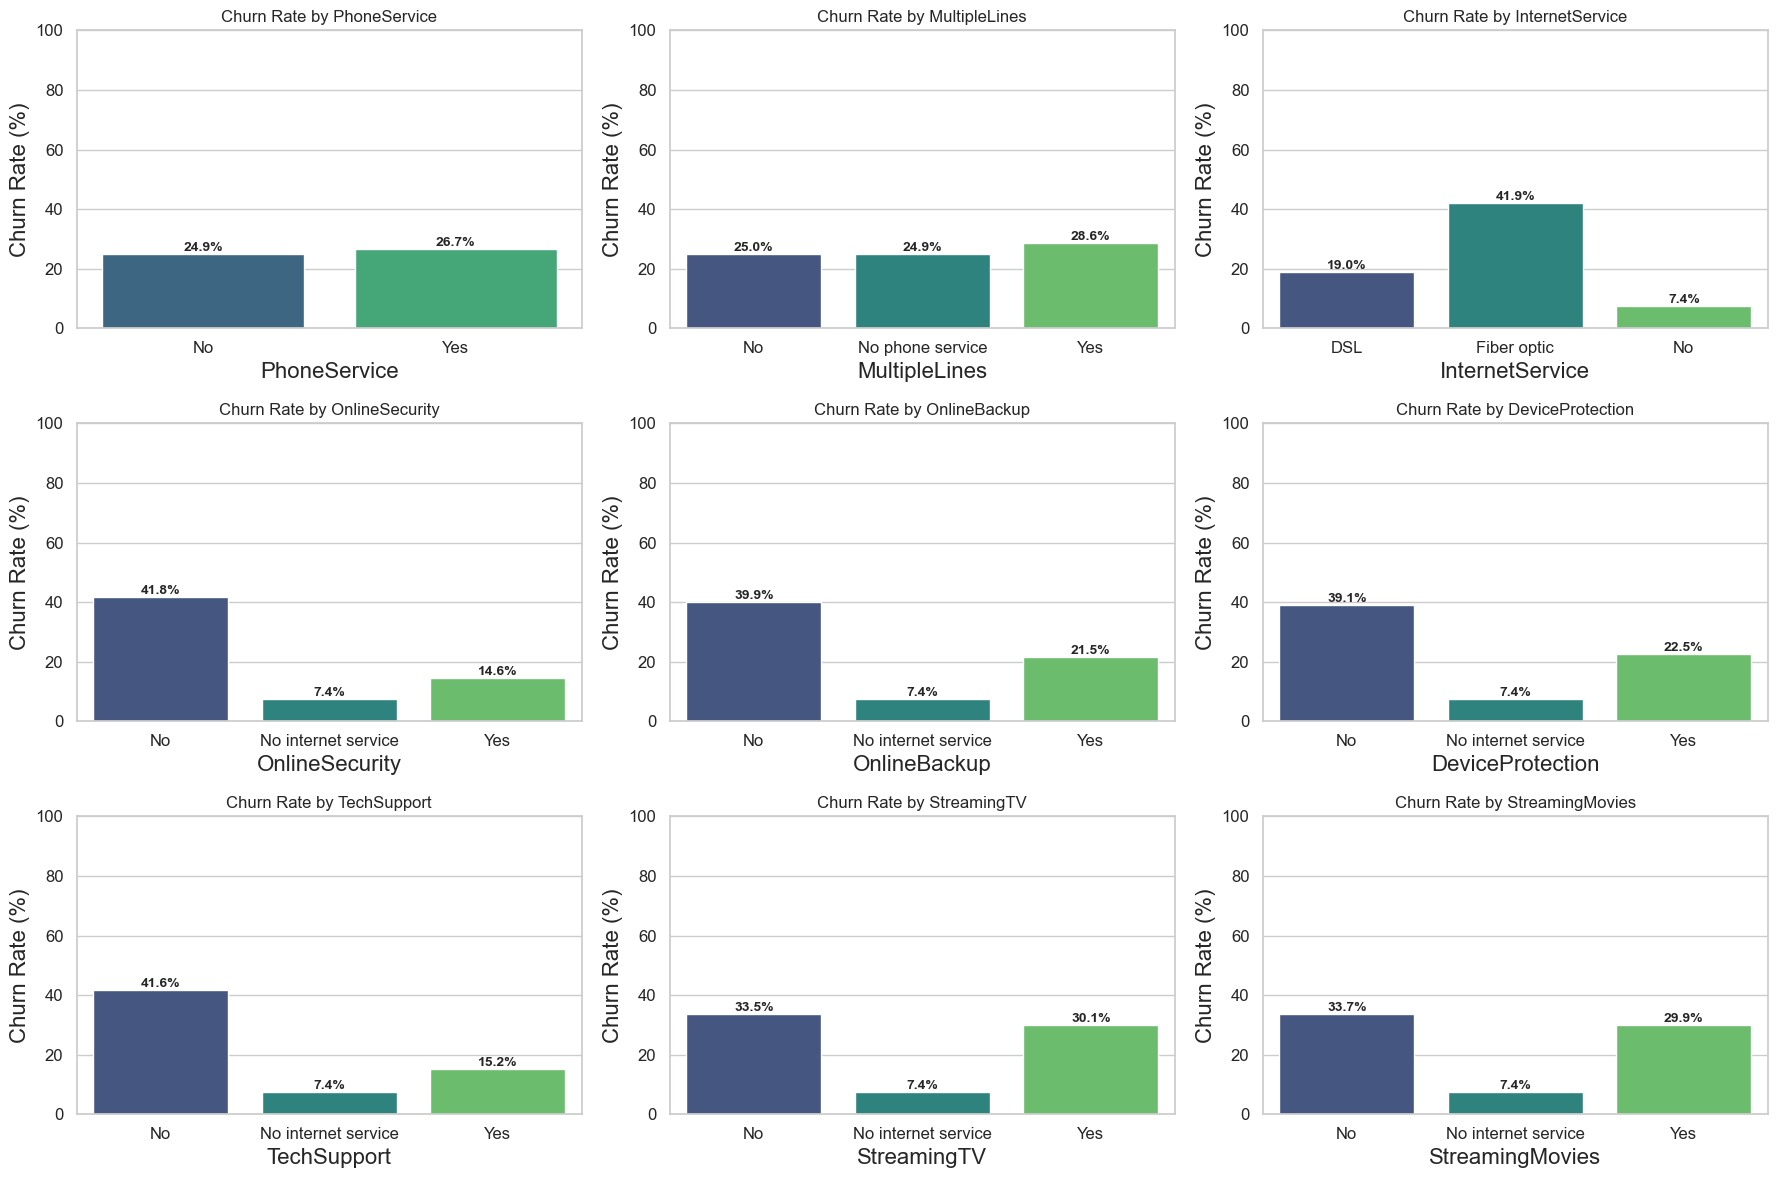

In [67]:
# List of service-related columns to analyze churn against
service_columns = [
    'PhoneService', 'MultipleLines', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]

# Create a subplot grid for visualizing churn rate by each service feature
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.flatten()

# Plot churn rate for each service feature with percentage labels
for i, column in enumerate(service_columns):
    churn_rates = df.groupby(column)['Churn'].value_counts(normalize=True).unstack().fillna(0) * 100
    sns.barplot(x=churn_rates.index, y=churn_rates['Yes'], ax=axes[i], palette='viridis')
    axes[i].set_title(f'Churn Rate by {column}')
    axes[i].set_ylabel("Churn Rate (%)")
    axes[i].set_xlabel(column)
    axes[i].set_ylim(0, 100)

    # Add percentage labels
    for j, value in enumerate(churn_rates['Yes']):
        axes[i].text(j, value + 1, f'{value:.1f}%', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig("../plots/churn_rate_by_service_features.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
#### 9. Churn Rate by Service Features
#### Customers without value-added services (e.g., OnlineSecurity, TechSupport) show higher churn.
#### Especially significant churn among those using **Fiber optic internet** and no **OnlineBackup** or **DeviceProtection**.

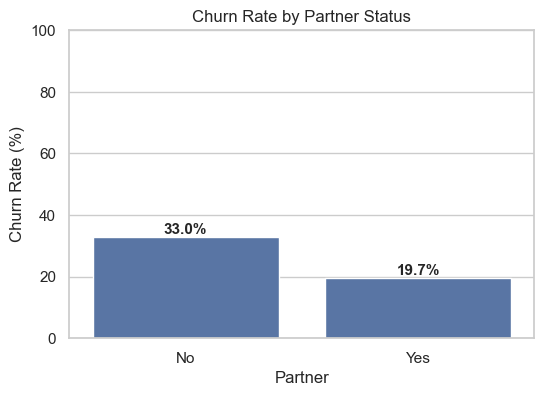

In [69]:
# Set up the plot style
sns.set(style="whitegrid")

# Calculate churn rates for Partner status
churn_by_partner = df.groupby('Partner')['Churn'].value_counts(normalize=True).unstack().fillna(0) * 100

# Plot churn rate by Partner status with percentage labels
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=churn_by_partner.index, y=churn_by_partner['Yes'])
plt.ylabel("Churn Rate (%)")
plt.title("Churn Rate by Partner Status")
plt.ylim(0, 100)

# Add percentage labels
for i, value in enumerate(churn_by_partner['Yes']):
    ax.text(i, value + 1, f'{value:.1f}%', ha='center', fontsize=11, fontweight='bold')
plt.savefig("../plots/churn_rate_by_partner_status.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
#### 10. Churn Rate by Partner and Dependents
#### Customers without partners or dependents show almost double the churn rate compared to those with.
#### These demographics may signal less stable or cost-sensitive segments.


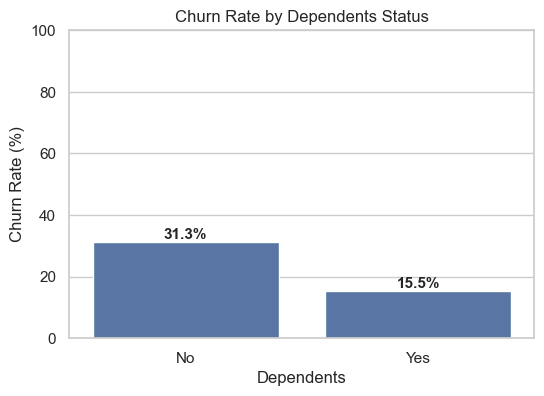

In [71]:
# Calculate churn rates for Dependents status
churn_by_dependents = df.groupby('Dependents')['Churn'].value_counts(normalize=True).unstack().fillna(0) * 100

# Plot churn rate by Dependents status with percentage labels
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=churn_by_dependents.index, y=churn_by_dependents['Yes'])
plt.ylabel("Churn Rate (%)")
plt.title("Churn Rate by Dependents Status")
plt.ylim(0, 100)

# Add percentage labels
for i, value in enumerate(churn_by_dependents['Yes']):
    ax.text(i, value + 1, f'{value:.1f}%', ha='center', fontsize=11, fontweight='bold')
plt.savefig("../plots/churn_rate_by_dependents_status.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
#### 11. Churn Rate by Partner and Dependents
#### Customers without partners or dependents show almost double the churn rate compared to those with.
#### These demographics may signal less stable or cost-sensitive segments.

### Key Insights:
### Churn is strongly linked to tenure, contract type, payment method, and value-added services.
### Demographic indicators (like having dependents or a partner) reduce churn risk.

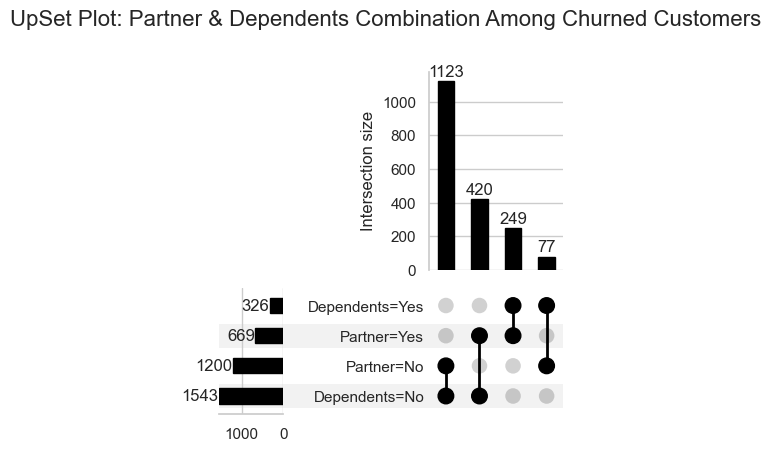

In [73]:
# Filter for churned customers only
df_churned = df[df['Churn'] == 'Yes']

# Selected features for UpSet analysis
selected_features = ['Partner', 'Dependents']

# Create membership tuples like ('Partner=Yes', 'Dependents=No')
memberships = [
    tuple(f"{feature}={row[feature]}" for feature in selected_features)
    for _, row in df_churned.iterrows()
]

# Create the UpSet plot data
upset_data = from_memberships(memberships)

# Plot with constrained_layout to prevent title from being cut off
fig = plt.figure(figsize=(10, 6))
upset = UpSet(upset_data, subset_size='count', show_counts=True, sort_by='cardinality')
upset.plot(fig=fig)
fig.suptitle("UpSet Plot: Partner & Dependents Combination Among Churned Customers", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig("../plots/upset_partner_dependents_churned.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
#The largest group of churned customers were those without partners and dependents (n=1123), 
#confirming earlier bar chart findings and highlighting this group as highly at-risk.

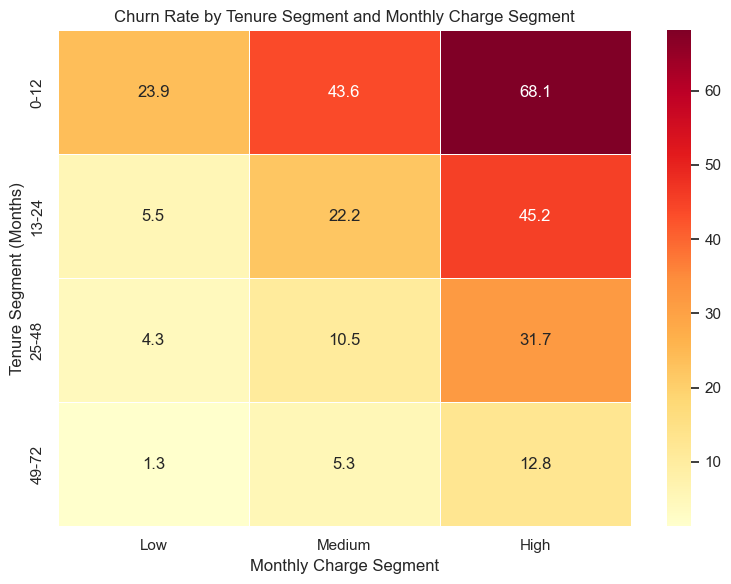

In [75]:
# Convert Churn column to binary
df['Churn_numeric'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Create tenure and monthly charge segments
df['TenureSegment'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 72], labels=['0-12', '13-24', '25-48', '49-72'])
df['ChargeSegment'] = pd.cut(df['MonthlyCharges'], bins=[0, 35, 70, 105], labels=['Low', 'Medium', 'High'])

# Calculate churn rate by segment
segment_churn = df.groupby(['TenureSegment', 'ChargeSegment'])['Churn_numeric'].mean().unstack() * 100

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(segment_churn, annot=True, fmt=".1f", cmap="YlOrRd", linewidths=0.5)
plt.title("Churn Rate by Tenure Segment and Monthly Charge Segment")
plt.ylabel("Tenure Segment (Months)")
plt.xlabel("Monthly Charge Segment")
plt.tight_layout()
plt.savefig("../plots/segment_churn_heatmap.png", dpi=300)
plt.show()


In [ ]:
#The highest churn (68.1%) is seen in customers with low tenure (0–12 months) and high monthly charges. 
#These customers should be prioritized for intervention programs.

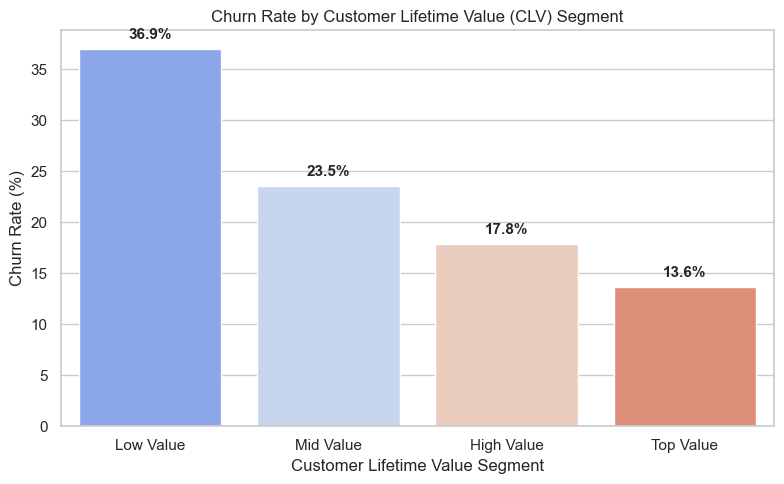

In [77]:
# Estimate a basic Customer Lifetime Value (CLV) approximation
df['CLV'] = df['MonthlyCharges'] * df['tenure']

# Create CLV bins
df['CLVSegment'] = pd.cut(df['CLV'], bins=[0, 1000, 3000, 5000, df['CLV'].max()],
                          labels=['Low Value', 'Mid Value', 'High Value', 'Top Value'])

# Convert 'Churn' to numeric (Yes=1, No=0)
df['ChurnNumeric'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Calculate churn rate by CLV segment
clv_churn = df.groupby('CLVSegment')['ChurnNumeric'].mean() * 100

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=clv_churn.index, y=clv_churn.values, palette='coolwarm')
plt.ylabel("Churn Rate (%)")
plt.xlabel("Customer Lifetime Value Segment")
plt.title("Churn Rate by Customer Lifetime Value (CLV) Segment")

# Add percentage labels
for i, value in enumerate(clv_churn.values):
    plt.text(i, value + 1, f'{value:.1f}%', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig("../plots/clv_churn_rate.png", dpi=300)
plt.show()


In [ ]:
#Churn decreases with increasing CLV:
#Low CLV: 36.9% churn, Top CLV: 13.6% churn
#Retention strategies should prioritize converting low-value customers to higher-value tiers through upselling or value-added services.

In [79]:
# Define categorical columns
categorical_columns = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]

# Run chi-square tests and collect results
chi_square_results = []
for col in categorical_columns:
    contingency_table = pd.crosstab(df[col], df['Churn'])
    chi2, p, _, _ = stats.chi2_contingency(contingency_table)
    chi_square_results.append((col, p))

# Create and return sorted DataFrame
chi_square_df = pd.DataFrame(chi_square_results, columns=['Feature', 'p_value']).sort_values(by='p_value')
chi_square_df.reset_index(drop=True, inplace=True)
chi_square_df.head(10)


,Feature,p_value
0,Contract,5.863038e-258
1,OnlineSecurity,2.661150e-185
2,TechSupport,1.443084e-180
3,InternetService,9.571788e-160
4,PaymentMethod,3.682355e-140
5,OnlineBackup,2.079759e-131
6,DeviceProtection,5.505219e-122
7,StreamingMovies,2.667757e-82
8,StreamingTV,5.528994e-82
9,PaperlessBilling,4.073355e-58


In [65]:
#The Chi-Square Test is a statistical test used to determine whether there is a significant association between two categorical variables.
#Chi-square tests reveal that several categorical features such as Contract, PaymentMethod, TechSupport,
#OnlineSecurity, and InternetService have p-values < 0.05, indicating statistically significant association with churn.

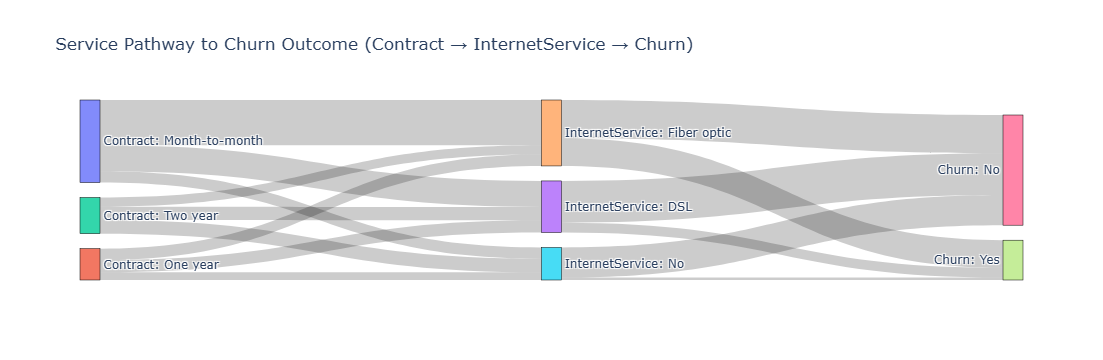

In [81]:
# Prepare dataset
sankey_df = df[['Contract', 'InternetService', 'Churn']].copy()

# Define stages
stages = ['Contract', 'InternetService', 'Churn']

# Add stage names to labels for clarity
sankey_labeled = sankey_df.copy()
for col in stages:
    sankey_labeled[col] = col + ': ' + sankey_labeled[col].astype(str)

# Create a unique label list
label_list = []
for col in stages:
    label_list.extend(sankey_labeled[col].unique())
labels = list(pd.unique(label_list))

# Map transitions between stages
source, target, value = [], [], []
for i in range(len(stages) - 1):
    grouped = sankey_labeled.groupby([stages[i], stages[i + 1]]).size().reset_index(name='count')
    for _, row in grouped.iterrows():
        source.append(labels.index(row[stages[i]]))
        target.append(labels.index(row[stages[i + 1]]))
        value.append(row['count'])

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, line=dict(color="black", width=0.5), label=labels),
    link=dict(source=source, target=target, value=value)
)])
fig.update_layout(title_text="Service Pathway to Churn Outcome (Contract → InternetService → Churn)", font_size=12)
fig.show()


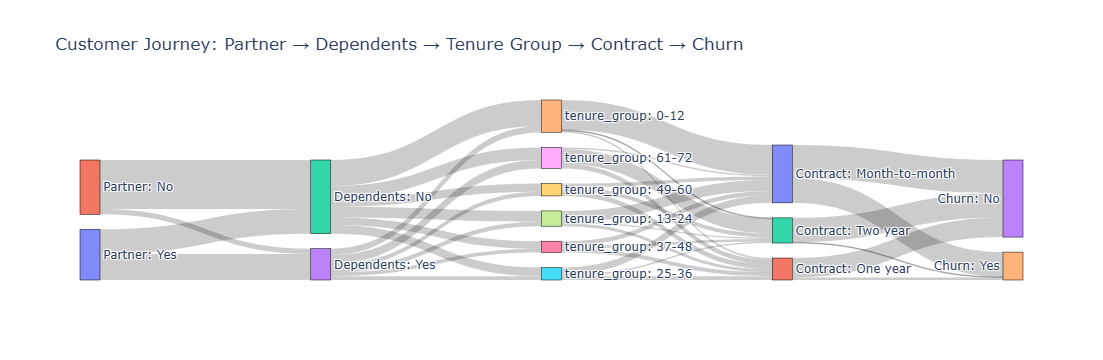

In [83]:

# Prepare dataset
sankey_df = df[['Partner', 'Dependents', 'tenure', 'Contract', 'Churn']].copy()
sankey_df['tenure_group'] = pd.cut(sankey_df['tenure'], bins=[0, 12, 24, 36, 48, 60, 72], 
                                   labels=['0-12', '13-24', '25-36', '37-48', '49-60', '61-72'])

# Define stages
stages = ['Partner', 'Dependents', 'tenure_group', 'Contract', 'Churn']

# Add stage names to labels for clarity
sankey_labeled = sankey_df.dropna().copy()
for col in stages:
    sankey_labeled[col] = col + ': ' + sankey_labeled[col].astype(str)

# Create unique label list
label_list = []
for col in stages:
    label_list.extend(sankey_labeled[col].unique())
labels = list(pd.unique(label_list))

# Map transitions between stages
source, target, value = [], [], []
for i in range(len(stages) - 1):
    grouped = sankey_labeled.groupby([stages[i], stages[i + 1]]).size().reset_index(name='count')
    for _, row in grouped.iterrows():
        source.append(labels.index(row[stages[i]]))
        target.append(labels.index(row[stages[i + 1]]))
        value.append(row['count'])

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, line=dict(color="black", width=0.5), label=labels),
    link=dict(source=source, target=target, value=value)
)])
fig.update_layout(title_text="Customer Journey: Partner → Dependents → Tenure Group → Contract → Churn", font_size=12)
fig.show()
